# Seq2Seq with Attention for German-English Neural Machine Translation
- Network architecture based on this [paper](https://arxiv.org/abs/1409.0473)
- Fit to run on Google Colaboratory

In [0]:
import os
import io
import math
import time
import random

import spacy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.data import Field, BucketIterator
from torchtext.datasets import TranslationDataset, Multi30k

## Set random seed

In [0]:
SEED = 2015010720
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Check Spacy (이미 설치되어 있음)

In [0]:
# 설치가 되어있는지 확인
!pip show spacy

Name: spacy
Version: 2.1.6
Summary: Industrial-strength Natural Language Processing (NLP) with Python and Cython
Home-page: https://spacy.io
Author: Explosion AI
Author-email: contact@explosion.ai
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: thinc, cymem, numpy, blis, murmurhash, requests, preshed, wasabi, srsly, plac
Required-by: fastai, en-core-web-sm


In [0]:
# 설치가 되어있는지 확인 (없다면 자동설치됨)
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 11.1MB 742kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.1.0-cp36-none-any.whl size=11073066 sha256=2e7f3433e199ecbd355082d68ac6f63e08eef2b287074a18b6bd6c1a15324840
  Stored in directory: /tmp/pip-ephem-wheel-cache-i2_56hpe/wheels/b4/8b/5e/d2ce5d2756ca95de22f50f68299708009a4aafda2aea79c4e4
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [0]:
import spacy
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

# 1. Define Tokenizing Functions
문장을 받아 그보다 작은 어절 혹은 형태소 단위의 리스트로 반환해주는 함수를 각 언어에 대해 작성

## German Tokenizer

In [0]:
def tokenize_de(text):
    return [t.text for t in spacy_de.tokenizer(text)]

In [0]:
# Usage example
print(tokenize_de("Was ich nicht erschaffen kann, verstehe ich nicht."))

['Was', 'ich', 'nicht', 'erschaffen', 'kann', ',', 'verstehe', 'ich', 'nicht', '.']


## English Tokenizer

In [0]:
def tokenize_en(text):
    return [t.text for t in spacy_en.tokenizer(text)]

In [0]:
# Usage example
print(tokenize_en("What I cannot create, I don't understand."))

['What', 'I', 'can', 'not', 'create', ',', 'I', 'do', "n't", 'understand', '.']


# 2. Data Preprocessing

##Define Fields

In [0]:
GERMAN = Field(
    tokenize = tokenize_de, 
    init_token='<sos>', 
    eos_token='<eos>', 
    lower=True, 
    include_lengths=True,
    batch_first=False  # time first
)

ENGLISH = Field(
    tokenize=tokenize_en, 
    init_token='<sos>', 
    eos_token='<eos>',
    lower=True,
    include_lengths=True,
    batch_first=False  # time first
)

## Load Data

In [0]:
train_set, valid_set, test_set = Multi30k.splits(
    exts=('.de', '.en'),
    fields=(GERMAN, ENGLISH)
)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 505kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 156kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 148kB/s]


In [0]:
print('#. train examples:', len(train_set.examples))
print('#. valid examples:', len(valid_set.examples))
print('#. test examples:', len(test_set.examples))

#. train examples: 29000
#. valid examples: 1014
#. test examples: 1000


In [0]:
# Training example (GERMAN, source language)
train_set.examples[50].src

['ein',
 'junge',
 'in',
 'einer',
 'roten',
 'jacke',
 ',',
 'der',
 'wasser',
 'auf',
 'einen',
 'mann',
 'in',
 'einem',
 'weißen',
 'hemd',
 'gießt',
 '.']

In [0]:
# Training example (ENGLISH, target language)
train_set.examples[50].trg

['a',
 'boy',
 'in',
 'a',
 'red',
 'jacket',
 'pouring',
 'water',
 'on',
 'a',
 'man',
 'in',
 'a',
 'white',
 'shirt']

## Build Vocabulary
- 각 언어별 생성: `Field`의 인스턴스를 활용
- 최소 빈도수(`MIN_FREQ`) 값을 작게 하면 vocabulary의 크기가 커짐.
- 최소 빈도수(`MIN_FREQ`) 값을 크게 하면 vocabulary의 크기가 작아짐.


In [0]:
MIN_FREQ = 2  # TODO: try different values

### German vocab

In [0]:
# Build vocab for German
GERMAN.build_vocab(train_set, min_freq=MIN_FREQ)  # de
print('Size of source vocab (de):', len(GERMAN.vocab))

Size of source vocab (de): 7855


In [0]:
GERMAN.vocab.freqs.most_common(10)

[('.', 28821),
 ('ein', 18850),
 ('einem', 13711),
 ('in', 11893),
 ('eine', 9908),
 (',', 8938),
 ('und', 8925),
 ('mit', 8843),
 ('auf', 8745),
 ('mann', 7805)]

In [0]:
# Check indices of some important tokens
tokens = ['<unk>', '<pad>', '<sos>', '<eos>']
for token in tokens:
    print(f"{token} -> {GERMAN.vocab.stoi[token]}")

<unk> -> 0
<pad> -> 1
<sos> -> 2
<eos> -> 3


### English vocab

In [0]:
# Build vocab for English
ENGLISH.build_vocab(train_set, min_freq=MIN_FREQ)  # en
print('Size of target vocab (en):', len(ENGLISH.vocab))

Size of target vocab (en): 5893


In [0]:
ENGLISH.vocab.freqs.most_common(10)

[('a', 49165),
 ('.', 27623),
 ('in', 14886),
 ('the', 10955),
 ('on', 8035),
 ('man', 7781),
 ('is', 7525),
 ('and', 7379),
 ('of', 6871),
 ('with', 6179)]

In [0]:
# Check indices of some important tokens
tokens = ['<unk>', '<pad>', '<sos>', '<eos>']
for token in tokens:
    print(f"{token} -> {ENGLISH.vocab.stoi[token]}")

<unk> -> 0
<pad> -> 1
<sos> -> 2
<eos> -> 3


## Configure Device
- *'런타임'  -> '런타임 유형변경'* 에서 하드웨어 가속기로 **GPU** 선택

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device to use:', device)

Device to use: cuda


## Create Data Iterators
- 데이터를 미니배치(mini-batch) 단위로 반환해주는 역할
- `train_set`, `dev_set`, `test_set`에 대해 개별적으로 정의해야 함
- `BATCH_SIZE`를 정의해주어야 함
- `torchtext.data.BucketIterator`는 하나의 미니배치를 서로 비슷한 길이의 관측치들로 구성함
- [Bucketing](https://medium.com/@rashmi.margani/how-to-speed-up-the-training-of-the-sequence-model-using-bucketing-techniques-9e302b0fd976)의 효과: 하나의 미니배치 내 padding을 최소화하여 연산의 낭비를 줄여줌


In [0]:
BATCH_SIZE = 128

In [0]:
#from torchtext.data import BucketIterator

# Train iterator
train_iterator = BucketIterator(
    train_set,
    batch_size=BATCH_SIZE,
    train=True,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

print(f'Number of minibatches per epoch: {len(train_iterator)}')

Number of minibatches per epoch: 227


In [0]:
#from torchtext.data import BucketIterator

# Dev iterator
valid_iterator = BucketIterator(
    valid_set,
    batch_size=BATCH_SIZE,
    train=False,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

print(f'Number of minibatches per epoch: {len(valid_iterator)}')

Number of minibatches per epoch: 8


In [0]:
#from torchtext.data import BucketIterator

# Test iterator
test_iterator = BucketIterator(
    test_set,
    batch_size=BATCH_SIZE,
    train=False,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

print(f'Number of minibatches per epoch: {len(test_iterator)}')

Number of minibatches per epoch: 8


In [0]:
train_batch = next(iter(train_iterator))
src, src_len = train_batch.src
trg, trg_len = train_batch.trg
print('a batch of source examples has shape:', src.size())  # (source_seq_len, batch_size)
print('a batch of target examples has shape:', trg.size())  # (target_seq_len, batch_size)

a batch of source examples has shape: torch.Size([12, 128])
a batch of target examples has shape: torch.Size([20, 128])


In [0]:
src

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   8,    5,    5,  ...,   18,    5,    5],
        [  36,  116,   26,  ...,   41,   13, 2797],
        ...,
        [  72, 2064,  449,  ...,  969,    0,   73],
        [   4,    4,    4,  ...,    4,    4,    4],
        [   3,    3,    3,  ...,    3,    3,    3]], device='cuda:0')

In [0]:
src_len # sorted in descending order

tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12], device='cuda:0')

In [0]:
trg

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,   74,    4,  ...,   16,    4,    4],
        [  38,   30,   34,  ...,   19,    9, 1880],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

In [0]:
trg_len

tensor([13, 13, 14, 12, 16, 12, 15, 12, 12, 12, 16, 11, 14, 15, 12, 15, 13, 12,
        16, 13, 13, 12, 16, 15, 11, 16, 15, 13, 12, 15, 12, 15, 11, 18,  8, 12,
        15, 13, 11, 12, 13, 11, 11, 12, 12, 14, 12, 12, 14, 13, 15, 14, 13, 13,
        13, 14, 15, 13, 11, 14, 14, 14, 11, 12, 17, 14, 12, 11, 13, 10, 14, 12,
        13, 15, 11, 13, 11,  9, 12, 15, 15, 16, 11, 13, 13, 13, 15, 12, 14, 11,
        14, 12, 13, 13, 12, 14,  9, 15, 16, 14, 13, 10, 14, 14, 13, 11, 16, 11,
        15, 13, 20, 12, 12, 15, 13, 16, 13, 14, 16, 12,  8, 12, 13, 14, 13, 13,
        14, 14], device='cuda:0')

In [0]:
# Checking last sample in mini-batch (GERMAN, source lang)
src, src_len = train_batch.src
de_indices = src[:, -1]
de_tokens = [GERMAN.vocab.itos[i] for i in de_indices]
for t, i in zip(de_tokens, de_indices):
    print(f"{t} ({i})")
    
del de_indices, de_tokens

<sos> (2)
ein (5)
dj (2797)
dreht (712)
platten (3986)
in (7)
einem (6)
klub (6542)
voller (266)
leute (73)
. (4)
<eos> (3)


In [0]:
# Checking last sample in mini-batch (EN, target lang)
trg, trg_len = train_batch.trg
en_indices = trg[:, -1]
en_tokens = [ENGLISH.vocab.itos[i] for i in en_indices]
for t, i in zip(en_tokens, en_indices):
    print(f"{t} ({i})")
    
del en_indices, en_tokens

<sos> (2)
a (4)
dj (1880)
is (10)
spinning (1448)
records (4334)
at (20)
a (4)
club (1116)
full (298)
of (12)
people (19)
. (5)
<eos> (3)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)


# 3. Building Seq2Seq Model

## Hyperparameters

In [0]:
# Hyperparameters
INPUT_DIM = len(GERMAN.vocab)
OUTPUT_DIM = len(ENGLISH.vocab)
ENC_EMB_DIM = DEC_EMB_DIM = 256
ENC_HID_DIM = DEC_HID_DIM = 512
USE_BIDIRECTIONAL = False

print('source vocabulary size:', INPUT_DIM)
print('source word embedding size:', ENC_EMB_DIM)
print(f'encoder RNN hidden size: {ENC_HID_DIM} ({ENC_HID_DIM * 2} if bidirectional)')
print('-' * 50)
print('target vocabulary size:', OUTPUT_DIM)
print('target word embedding size:', ENC_EMB_DIM)
print('decoder RNN hidden size:', ENC_HID_DIM)

source vocabulary size: 7855
source word embedding size: 256
encoder RNN hidden size: 512 (1024 if bidirectional)
--------------------------------------------------
target vocabulary size: 5893
target word embedding size: 256
decoder RNN hidden size: 512


## Encoder

In [0]:
class Encoder(nn.Module):
    """
    Learns an embedding for the source text.
        Arguments:
        input_dim: int, size of input language vocabulary.
        emb_dim: int, size of embedding layer output.
        enc_hid_dim: int, size of encoder hidden state.
        dec_hid_dim: int, size of decoder hidden state.
        bidirectional: uses bidirectional RNNs if True. default is False.
    """
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, bidirectional=False):
        
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(
            num_embeddings=self.input_dim,
            embedding_dim=self.emb_dim
        )
        
        self.rnn = nn.GRU(
            input_size=self.emb_dim,
            hidden_size=self.enc_hid_dim,
            bidirectional=self.bidirectional,
            batch_first=False
        )
        
        self.rnn_output_dim = self.enc_hid_dim
        if self.bidirectional:
            self.rnn_output_dim *= 2
        
        self.fc = nn.Linear(self.rnn_output_dim, self.dec_hid_dim)
        self.dropout = nn.Dropout(.2)
        
    def forward(self, src, src_len):
        """
        Arguments:
            src: 2d tensor of shape (S, B)
            src_len: 1d tensor of shape (B).
        Returns:
            outputs: 3d tensor of shape (input_seq_len, batch_size, num_directions * enc_h)
            hidden: 2d tensor of shape (b, dec_h). This tensor will be used as the initial
                hidden state value of the decoder (h0 of decoder).
        """
        
        assert len(src.size()) == 2, 'Input requires dimension (input_seq_len, batch_size).'
        
        # Shape: (b, s, h)
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        packed_outputs, hidden = self.rnn(packed_embedded)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        if self.bidirectional:
            # (2, b, enc_h) -> (b, 2 * enc_h)
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            # (1, b, enc_h) -> (b, enc_h)
            hidden = hidden.squeeze(0)
        
        # (b, num_directions * enc_h) -> (b, dec_h)
        hidden = self.fc(hidden)
        hidden = torch.tanh(hidden)
        
        return outputs, hidden  # (S, B, enc_h * num_directions), (B, dec_h)

## Attention

In [0]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, encoder_is_bidirectional=False):
        super(Attention, self).__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.encoder_is_bidirectional = encoder_is_bidirectional
        
        self.attention_input_dim = enc_hid_dim + dec_hid_dim
        if self.encoder_is_bidirectional:
            self.attention_input_dim += enc_hid_dim  # 2 * h_enc + h_dec
        
        self.linear = nn.Linear(self.attention_input_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        """
        Arguments:
            hidden: 2d tensor with shape (batch_size, dec_hid_dim).
            encoder_outputs: 3d tensor with shape (input_seq_len, batch_size, enc_hid_dim * num_directions).
            mask: 2d tensor with shape(batch_size, input_seq_len)
        """
        
        # Shape check
        assert hidden.dim() == 2
        assert encoder_outputs.dim() == 3
        
        seq_len, batch_size, _ = encoder_outputs.size()
        
        # (b, dec_h) -> (b, s, dec_h)
        hidden = hidden.unsqueeze(1).expand(-1, seq_len, -1)
        
        # (s, b, enc_h * num_directions) -> (b, s, enc_h * num_directions)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # concat; shape results in (b, s, enc_h + dec_h).
        # if encoder is bidirectional, (b, s, 2 * h_enc + h_dec).
        concat = torch.cat((hidden, encoder_outputs), dim=2)
        
        # energy; shape is (b, s, dec_h)
        energy = torch.tanh(self.linear(concat))
        
        # tile v; (dec_h, ) -> (b, dec_h) -> (b, dec_h, 1)
        v = self.v.unsqueeze(0).expand(batch_size, -1).unsqueeze(2)
        
        # attn; (b, s, dec_h) @ (b, dec_h, 1) -> (b, s, 1) -> (b, s)
        attn_scores = torch.bmm(energy, v).squeeze(-1)
        
        # mask padding indices
        attn_scores = attn_scores.masked_fill(mask == 0, -1e10)
        
        assert attn_scores.dim() == 2  # Final shape check: (b, s)
        
        return F.softmax(attn_scores, dim=1)

## Decoder

In [0]:
class Decoder(nn.Module):
    """
    Unlike the encoder, a single forward pass of
    a `Decoder` instance is defined for only a single timestep.
    Arguments:
        output_dim: int,
        emb_dim: int,
        enc_hid_dim: int,
        dec_hid_dim: int,
        attention_module: torch.nn.Module,
        encoder_is_bidirectional: False
    """
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention_module, encoder_is_bidirectional=False):
        super(Decoder, self).__init__()
        
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.encoder_is_bidirectional = encoder_is_bidirectional
        
        if isinstance(attention_module, nn.Module):
            self.attention_module = attention_module
        else:
            raise ValueError
        
        self.rnn_input_size = enc_hid_dim + emb_dim  # enc_h + dec_emb_dim
        if self.encoder_is_bidirectional:
            self.rnn_input_size += enc_hid_dim       # 2 * enc_h + dec_emb_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(
            input_size=self.rnn_input_size,
            hidden_size=dec_hid_dim,
            bidirectional=False,
            batch_first=False,
        )
        
        self.out_input_size = emb_dim + dec_hid_dim + enc_hid_dim
        if self.encoder_is_bidirectional:
            self.out_input_size += enc_hid_dim
        self.out = nn.Linear(self.out_input_size, output_dim)
        
        self.dropout = nn.Dropout(.2)
        
    def forward(self, inp, hidden, encoder_outputs, mask, temperature=1.):
        """
        Arguments:
            inp: 1d tensor with shape (batch_size, )
            hidden: 2d tensor with shape (batch_size, dec_hid_dim).
                This `hidden` tensor is the hidden state vector from the previous timestep.
            encoder_outputs: 3d tensor with shape (input_seq_len, batch_size, enc_hid_dim * num_directions).
            mask: 2d tensor of shape (batch_size, input_seq_len).
        """
        
        assert inp.dim() == 1
        assert hidden.dim() == 2
        assert encoder_outputs.dim() == 3
        
        # (b, ) -> (1, b)
        inp = inp.unsqueeze(0)
        
        # (1, b) -> (1, b, emb)
        embedded = self.embedding(inp)
        embedded = self.dropout(embedded)
                
        # attention probabilities; (b, s)
        attn_probs = self.attention_module(hidden, encoder_outputs, mask)
        
        # (b, 1, s)
        attn_probs = attn_probs.unsqueeze(1)
        
        # (s, b, ~) -> (b, s, ~)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # (b, 1, s) @ (b, s, ~) -> (b, 1, enc_h * num_directions)
        weighted = torch.bmm(attn_probs, encoder_outputs)
        
        # (1, b, ~)
        weighted = weighted.permute(1, 0, 2)
        
        # (b, 1, emb + enc_h * num_directions)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        # output; (b, 1, dec_h)
        # new_hidden; (1, b, dec_h)
        output, new_hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == new_hidden).all()
        
        embedded = embedded.squeeze(0)  # (1, b, emb) -> (b, emb)
        output = output.squeeze(0)      # (1, b, dec_h) -> (b, dec_h)
        weighted = weighted.squeeze(0)  # (1, b, enc_h * num_d) -> (b, enc_h * num_d)
        
        # output; (b, emb + enc_h + dec_h) -> (b, output_dim)
        # if encoder is bidirectional, (b, emb + 2 * enc_h + dec_h) -> (b, output_dim)
        output = self.out(torch.cat((output, weighted, embedded), dim=1))
        output = output / temperature
        
        return output, new_hidden.squeeze(0), attn_probs.squeeze(1)

## Seq2Seq

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx  # 1
        self.sos_idx = sos_idx  # 2
        self.eos_idx = eos_idx  # 3
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)  # (b, s)
        return mask
        
    def forward(self, src, src_len, trg=None, teacher_forcing_ratio=.5):
        
        batch_size = src.size(1)
        max_seq_len = trg.size(0) if trg is not None else 100
        
        trg_vocab_size = self.decoder.output_dim
        
        if trg is None:
            assert teacher_forcing_ratio == 0., "Must be zero during inference."
            inference = True
            trg = torch.zeros(max_seq_len, batch_size).long().fill_(self.sos_idx).to(self.device)
        else:
            inference = False
            
        # An empty tensor to store decoder outputs (time index first for faster indexing)
        outputs_shape = (max_seq_len, batch_size, trg_vocab_size)
        outputs = torch.zeros(outputs_shape).to(self.device)
        
        # empty tensor to store attention probs
        attns_shape = (max_seq_len, batch_size, src.size(0))
        attns = torch.zeros(attns_shape).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src, src_len)
        mask = self.create_mask(src)
        
        # first input to the decoder is '<sos>'
        # trg; shape (batch_size, seq_len)
        initial_dec_input = output = trg[0, :]  # get first timestep token
        
        for t in range(1, max_seq_len):
            
            output, hidden, attn = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output  # Save output for timestep t, for 1 <= t <= max_len
            attns[t] = attn
            
            _, idx = output.max(dim=1)
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            
            new_dec_input = output = trg[t] if teacher_force else idx
            
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attns[:t]
        
        return outputs, attns

## Build Model

In [0]:
# Define encoder
enc = Encoder(
    input_dim=INPUT_DIM,
    emb_dim=ENC_EMB_DIM,
    enc_hid_dim=ENC_HID_DIM,
    dec_hid_dim=DEC_HID_DIM,
    bidirectional=USE_BIDIRECTIONAL
)

print(enc)

Encoder(
  (embedding): Embedding(7855, 256)
  (rnn): GRU(256, 512)
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
# Define attention layer
attn = Attention(
    enc_hid_dim=ENC_HID_DIM,
    dec_hid_dim=DEC_HID_DIM,
    encoder_is_bidirectional=USE_BIDIRECTIONAL
)

print(attn)

Attention(
  (linear): Linear(in_features=1024, out_features=512, bias=True)
)


In [0]:
# Define decoder
dec = Decoder(
    output_dim=OUTPUT_DIM,
    emb_dim=DEC_EMB_DIM,
    enc_hid_dim=ENC_HID_DIM,
    dec_hid_dim=DEC_HID_DIM,
    attention_module=attn,
    encoder_is_bidirectional=USE_BIDIRECTIONAL
)

print(dec)

Decoder(
  (attention_module): Attention(
    (linear): Linear(in_features=1024, out_features=512, bias=True)
  )
  (embedding): Embedding(5893, 256)
  (rnn): GRU(768, 512)
  (out): Linear(in_features=1280, out_features=5893, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
PAD_IDX = GERMAN.vocab.stoi['<pad>']
SOS_IDX = ENGLISH.vocab.stoi['<sos>']
EOS_IDX = ENGLISH.vocab.stoi['<eos>']

print('PAD INDEX:', PAD_IDX)
print('SOS INDEX:', SOS_IDX)
print('EOS INDEX:', EOS_IDX)

PAD INDEX: 1
SOS INDEX: 2
EOS INDEX: 3


In [0]:
model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): GRU(256, 512)
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.2)
  )
  (decoder): Decoder(
    (attention_module): Attention(
      (linear): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(768, 512)
    (out): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.2)
  )
)


## Count trainable parameters

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 15,008,261 trainable parameters.


## Initialize trainable parameters

In [0]:
def init_parameters(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0., std=0.01)
        else:
            nn.init.constant_(param.data, 0.)

model.apply(init_parameters)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): GRU(256, 512)
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.2)
  )
  (decoder): Decoder(
    (attention_module): Attention(
      (linear): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(768, 512)
    (out): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.2)
  )
)

# 4. Train

## Optimizer
- Use `optim.Adam` or `optim.RMSprop`.

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)

## Loss function

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
print(f"<pad> index in target vocab (en): '{PAD_IDX}' will be ignored when loss is calculated.")

<pad> index in target vocab (en): '1' will be ignored when loss is calculated.


## Train function

In [0]:
def train(seq2seq_model, iterator, optimizer, criterion, grad_clip=1.0):
    
    seq2seq_model.train()
    
    epoch_loss = .0
    
    for i, batch in enumerate(iterator):
        
        print('.', end='')
        
        src, src_len = batch.src
        trg, _ = batch.trg
        
        optimizer.zero_grad()
        
        decoder_outputs, _ = seq2seq_model(src, src_len, trg, teacher_forcing_ratio=.5)
        trg_seq_len, batch_size, trg_vocab_size = decoder_outputs.size()  # (s, b, trg_vocab)
        
        # (s-1, b, trg_vocab)
        decoder_outputs = decoder_outputs[1:]
        
        # (s-1 * b, trg_vocab)
        decoder_outputs = decoder_outputs.view(-1, trg_vocab_size)
        
        # (s, b) -> (s-1 * b, )
        trg = trg[1:].view(-1)                                       

        loss = criterion(decoder_outputs, trg)
        loss.backward()
        
        # Gradient clipping; remedy for exploding gradients
        torch.nn.utils.clip_grad_norm_(seq2seq_model.parameters(), grad_clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Evaluate function

In [0]:
def evaluate(seq2seq_model, iterator, criterion):
    
    seq2seq_model.eval()
    
    epoch_loss = 0.
    
    with torch.no_grad():
        
        for i, batch in enumerate(iterator):
            
            print('.', end='')
            
            src, src_len = batch.src
            trg, _ = batch.trg
            
            decoder_outputs, _ = seq2seq_model(src, src_len, trg, teacher_forcing_ratio=0.)
            trg_seq_len, batch_size, trg_vocab_size = decoder_outputs.size()  # (s, b, trg_vocab)
        
            # (s-1, b, trg_vocab)
            decoder_outputs = decoder_outputs[1:]                 
        
            # (s-1 * b, trg_vocab)
            decoder_outputs = decoder_outputs.view(-1, trg_vocab_size)
            
            # (s, b) -> (s-1 * b, )
            trg = trg[1:].view(-1)
            
            loss = criterion(decoder_outputs, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

## Epoch time measure function

In [0]:
def epoch_time(start_time, end_time):
    """Returns elapsed time in mins & secs."""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Train for multiple epochs

In [0]:
NUM_EPOCHS = 10

In [0]:
best_valid_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './best_model_de2en.pt')
    
    print("\n")
    print(f"Epoch: {epoch + 1:>02d} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"Train Loss: {train_loss:>.4f} | Train Perplexity: {math.exp(train_loss):7.3f}")
    print(f"Valid Loss: {valid_loss:>.4f} | Valid Perplexity: {math.exp(valid_loss):7.3f}")

...........................................................................................................................................................................................................................................

Epoch: 01 | Time: 1m 18s
Train Loss: 5.1055 | Train Perplexity: 164.919
Valid Loss: 4.9291 | Valid Perplexity: 138.261
...........................................................................................................................................................................................................................................

Epoch: 02 | Time: 1m 18s
Train Loss: 4.2797 | Train Perplexity:  72.219
Valid Loss: 4.5825 | Valid Perplexity:  97.757
...........................................................................................................................................................................................................................................

Epoch: 03 | Time: 1m 18s
Train Loss: 3.6402 | Train

## Save last model (overfitted)

In [0]:
torch.save(model.state_dict(), './last_model_de2en.pt')

# 5. Test

## Evaluate on test data

In [0]:
model.load_state_dict(torch.load('best_model_de2en.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

........| Test Loss: 3.216 | Test PPL:  24.939 |


## Function to convert indices to original text strings (translate)

In [0]:
def translate_sentence(seq2seq_model, sentence):
    
    seq2seq_model.eval()
    
    # Tokenize sentence
    tokenized = tokenize_de(sentence)
    
    # lower tokens
    tokenized = [t.lower() for t in tokenized]
    
    # Add <sos> & <eos> tokens to the front and back of the sentence
    tokenized = ['<sos>'] + tokenized + ['<eos>']
    
    # tokens -> indices
    numericalized = [GERMAN.vocab.stoi[s] for s in tokenized]
    
    sent_length = torch.tensor([len(numericalized)]).long().to(device)
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device)
    
    translation_logits, attention = seq2seq_model(tensor, sent_length, None, 0.)
    translation_tensor = torch.argmax(translation_logits.squeeze(1), dim=1)
    translation = [ENGLISH.vocab.itos[i] for i in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    
    #assert translation.__len__() == 1  # (sequence_length, )
    #assert attention.dim() == 2
    
    return translation, attention

In [0]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_de(candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [0]:
example_idx = 4
src = ' '.join(train_set.examples[example_idx].src)
trg = ' '.join(train_set.examples[example_idx].trg)

print(f'src = {src}')
print(f'trg = {trg}')

src = zwei männer stehen am herd und bereiten essen zu .
trg = two men are at the stove preparing food .


In [0]:
translation, attention = translate_sentence(model, src)
print(f'predicted = {translation}')

predicted = ['two', 'men', 'are', 'at', 'the', 'stove', 'preparing', 'food', '.']


## Alignment

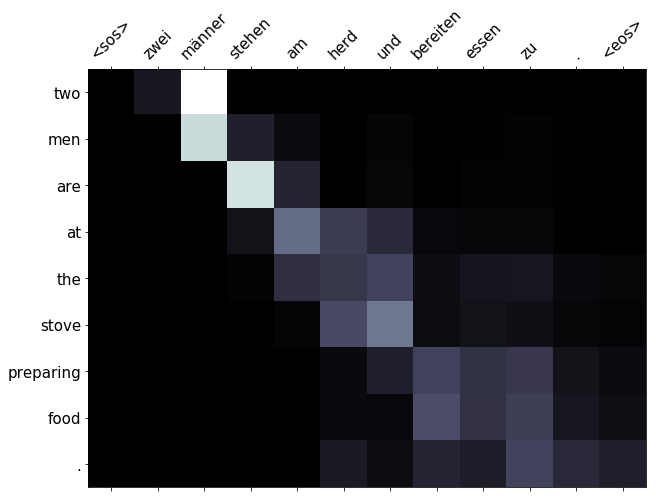

In [0]:
display_attention(src, translation, attention)

src = eine frau sitzt an einer dunklen bar .
trg = a woman sits at a dark bar .
predicted trg = ['a', 'woman', 'is', 'sitting', 'at', 'a', 'dark', 'bar', '.']


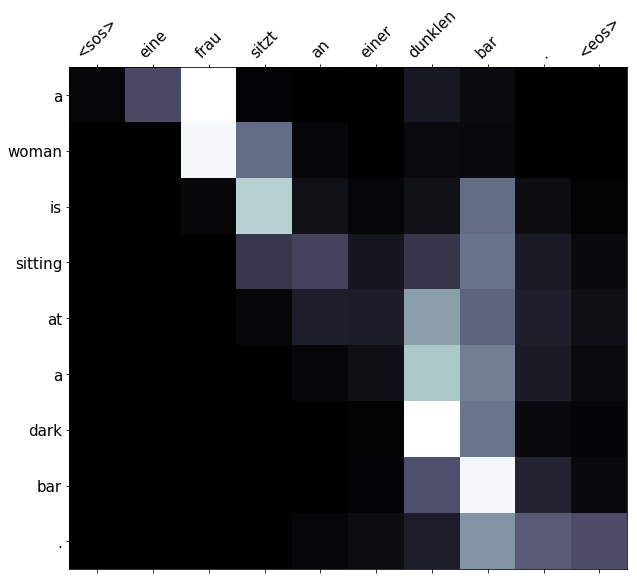

In [0]:
example_idx = 35

src = ' '.join(valid_set.examples[example_idx].src)
trg = ' '.join(valid_set.examples[example_idx].trg)

print(f'src = {src}')
print(f'trg = {trg}')


translation, attention = translate_sentence(model, src)
print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

src = ein junge in einem roten trikot versucht , die home base zu erreichen , während der catcher im blauen trikot versucht , ihn zu fangen .
trg = a boy in a red uniform is attempting to avoid getting out at home plate , while the catcher in the blue uniform is attempting to catch him .
predicted trg = ['a', 'boy', 'in', 'a', 'red', 'uniform', 'trying', 'to', 'catch', 'a', 'baseball', 'bat', 'to', 'the', 'the', 'blue', 'tries', 'to', 'block', 'blue', '.']


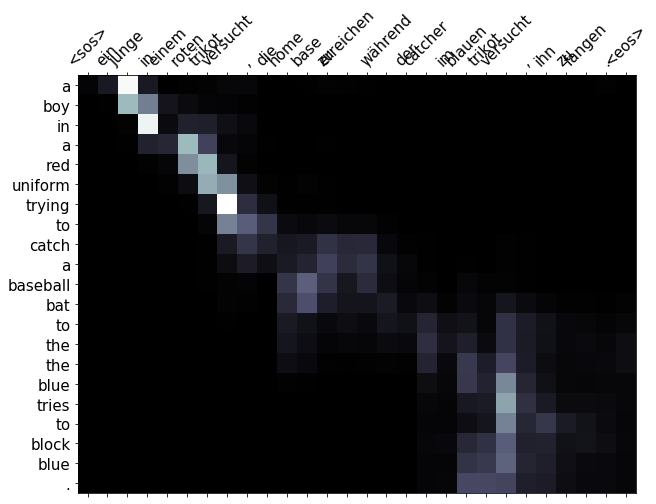

In [0]:
example_idx = 7

src = ' '.join(test_set.examples[example_idx].src)
trg = ' '.join(test_set.examples[example_idx].trg)

print(f'src = {src}')
print(f'trg = {trg}')


translation, attention = translate_sentence(model, src)
print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

# 6. Download Model

In [0]:
!ls -al

total 117284
drwxr-xr-x 1 root root     4096 Aug  1 20:26 .
drwxr-xr-x 1 root root     4096 Aug  1 18:15 ..
-rw-r--r-- 1 root root 60035816 Aug  1 20:20 best_model_de2en.pt
drwxr-xr-x 1 root root     4096 Jul 30 16:17 .config
drwxr-xr-x 3 root root     4096 Aug  1 19:44 .data
-rw-r--r-- 1 root root 60035816 Aug  1 20:26 last_model_de2en.pt
drwxr-xr-x 1 root root     4096 Jul 30 16:17 sample_data


In [0]:
from google.colab import files
print('Downloading best model...')  # Known bug; if using Firefox, a print statement in the same cell is necessary.
files.download('./best_model_de2en.pt')

In [0]:
print('Downloading last model...')  # Known bug; if using Firefox, a print statement in the same cell is necessary.
files.download('./last_model_de2en.pt')